In [84]:
import numpy as np
import pandas as pd
import xarray as xr
from config import DOWNLOAD_DIR, INPUT_DIR

### Merge datasets, create daily sum of total precipitation

We need to merge the three (sometimes two?) datasets into a single dataframe.  Then, we need to produce total sums for each day.  Source data will contain a [mix of ERA5 and ERA5T data](https://confluence.ecmwf.int/display/CUSF/ERA5+CDS+requests+which+return+a+mixture+of+ERA5+and+ERA5T+data), so we need to do this to get a consistent set of data:
 
### Our algorithm for merging/fusing data needs to go like this,


 1. Some data files may not have `expver` present at all, such as older data which are outside the window of modification for the rolling ERA5 updates.  Use those data as-is.
 1. If `expver` has both values 1 and 5 (a mix of ERA5 and ERA5T data), choose `expver == 1` where possible, and `expver == 5` for timesteps when `expver == 1` is missing.
 1. For recent data, only `expver` value 5 is present.

#### Notes/Questions?

 * Current month may be only ERA5T / `expver = 5`
 * Prior months in the same year may have mix of `expver` 5 and 1.
 * Prior year doesn't have `expver`.


Needs to be robust to the presence/absence of expver.

Goal is that a dataframe taken for a single point looks correct with data for every timestep (no dupes, no missing).

## TODO: make this work properly for January when we may only have 2 data files.

In [2]:
prior_year = xr.open_dataset(DOWNLOAD_DIR.joinpath("inputs/total_precipitation_previous_year.nc"))
current_year = xr.open_dataset(DOWNLOAD_DIR.joinpath("inputs/total_precipitation_current_year.nc"))
current_month = xr.open_dataset(DOWNLOAD_DIR.joinpath("inputs/total_precipitation_current_month.nc"))

Test hypothesis that value ERA5 data is NaN when ERA5T is not NaN and vice versa.

if both of these startments print `True` then this hypothesis is True.

This probably doesn't matter much for implementation but it's good to know perhaps. Will remove, this just keeping for crosstraining. Maybe should actually keep this and assert it because it does allow a simplified selection of the desired values, and if this ever changes we would then know where to look faster.

In [3]:
print(np.all(np.isnan(current_year["tp"].sel(expver=5)) == ~np.isnan(current_year["tp"].sel(expver=1))).values)
print(np.all(~np.isnan(current_year["tp"].sel(expver=5)) == np.isnan(current_year["tp"].sel(expver=1))).values)

True
True


Now we know we can just select the data for each `expver` value and we should be able to combine to get a complete continuous set of data:

In [5]:
current_year_fix = xr.merge([
    current_year["tp"].sel(expver=1).drop("expver"),
    current_year["tp"].sel(expver=5).drop("expver")
])

Make sure that there are no NaNs:

In [6]:
np.any(np.isnan(current_year_fix["tp"]).values)

False

Now merge with other dataset since they all share the same coordinate variables now:

In [15]:
tp_ds_hourly = xr.merge([
    prior_year,
    current_year_fix,
    current_month_daily,
])

And resample the hourly data to daily:

In [16]:
tp_ds = tp_ds_hourly.resample(time="1D").sum()

There we have it, total precip dataset:

In [17]:
tp_ds

<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 129, time: 651)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... -125.5 -125.2 -125.0
  * latitude   (latitude) float32 76.0 75.75 75.5 75.25 ... 44.5 44.25 44.0
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2022-10-13
Data variables:
    tp         (time, latitude, longitude) float32 1.345e-05 ... -1.118e-08

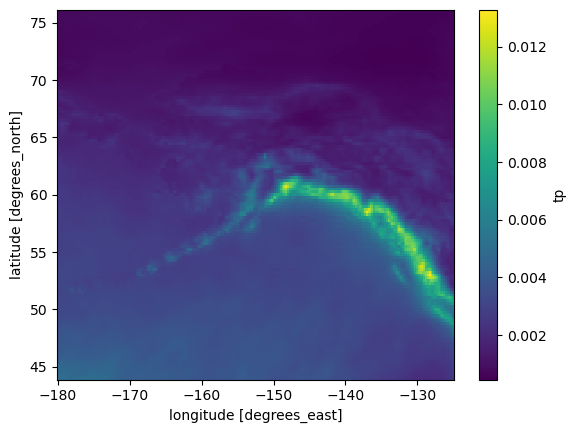

In [18]:
tp_ds["tp"].mean(dim="time").plot()

Just for fun, a look at the hourly data from last year's ROS event:

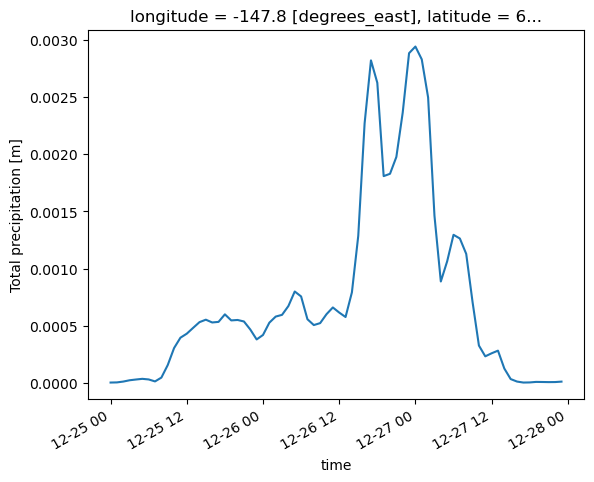

In [20]:
prior_year["tp"].sel(
    longitude=-147.72, latitude=64.84, method="nearest"
).sel(time=slice("2021-12-25", "2021-12-27")).plot()

## Indices

I know we have another notebook for processing these but we might consider just doing the preprocessing and processing in one go because the preprocessing is rather quick.

We will compute the following indices:

* SPI - standardized precipitation index
* SPEI (can ERA 5 do this?) – standardized potential evaporation index
* Total Precip
* % of Normal Precipitation
* SWE - snow water equivalent
* SWE % of Normal 
* Soil Moisture Deficit

These indices will be computed for the following time periods:

* 30 day
* 60 day
* 90 day
* 180 day
* 365 day

So we really will only want data as far back as 1 year from most recent data we have (right?), so we can do that first for our precip data:

In [68]:
end_time = tp_ds.time[-1]
start_time = tp_ds.time[-365]
# ensure that this is indeed 365 days (time diff is nanoseconds)
assert (end_time - start_time) / 86400E9
tp_ds_1yr = tp_ds.sel(time=slice(start_time, end_time))

Also we may want to have the 5 time intervals for repeated use:

In [69]:
intervals = [30, 60 , 90, 180, 365]
# also will be referencing the timestamps fairly often
times = tp_ds_1yr.time.values

Also create a dict for writing results maybe?

In [70]:
indices = {}

### Total precip

This one should be easy? Just sum over each time interval?

In [72]:
index = "tp"

indices[index] = {}
for i in intervals:
    indices[index][str(i)] = tp_ds_1yr["tp"].sel(time=slice(times[-(i)], times[-1])).sum(dim="time")

### % of Normal

So now this one should calculate the percent of the climatologies that the above total precip values represent over the same time windows.

In [108]:
index = "pnp"
indices[index] = {}
with xr.open_dataset(INPUT_DIR.joinpath("era5_daily_tp_climatology_1981_2020_leap.nc")) as tp_clim_ds:
    # need to remap longitude coordinates from [180, 360] to [-180, 0]
    tp_clim_ds = tp_clim_ds.assign_coords(longitude=(tp_clim_ds.longitude.values) - 360)
    for i in intervals:
        # corresponding time slice for climotology dataset
        climo_time_sl = slice(
            pd.Timestamp(times[-i]).dayofyear, pd.Timestamp(times[-i]).dayofyear
        )
        climo_tp = tp_clim_ds.sel(
            time=climo_time_sl,
            latitude=tp_climo_ds.latitude.values,
        ).sum(dim="time").rename({"tp": "pnp"})
        indices[index][str(i)] = climo_tp / indices["tp"][str(i)]

Just a quick show that leap day and 2/28 have the same climotology:

In [80]:
assert np.all(tp_climo_ds["tp"].sel(time=59) == tp_climo_ds["tp"].sel(time=60))